**<font size=5> SQL Scavenger Hunt </font>**

I have been aware of the power of BigQuery for a long time. Therefore, I can't be more excited to join this Scavenger Hunt. Hope myself can polish my SQL skills through this Scavenger Hunt. Cheers!

**<font size=5>Tutorial : How should you start with BigQuery</font>**

- **First, load the dataset**

In [1]:
# import package with helper functions 
import bq_helper

accidents  = bq_helper.BigQueryHelper(active_project="bigquery-public-data",
                                   dataset_name="nhtsa_traffic_fatalities")

- **Take a look at the tables**

In [2]:
accidents .list_tables()

['accident_2015',
 'accident_2016',
 'cevent_2015',
 'cevent_2016',
 'damage_2015',
 'damage_2016',
 'distract_2015',
 'distract_2016',
 'drimpair_2015',
 'drimpair_2016',
 'factor_2015',
 'factor_2016',
 'maneuver_2015',
 'maneuver_2016',
 'nmcrash_2015',
 'nmcrash_2016',
 'nmimpair_2015',
 'nmimpair_2016',
 'nmprior_2015',
 'nmprior_2016',
 'parkwork_2015',
 'parkwork_2016',
 'pbtype_2015',
 'pbtype_2016',
 'person_2015',
 'person_2016',
 'safetyeq_2015',
 'safetyeq_2016',
 'vehicle_2015',
 'vehicle_2016',
 'vevent_2015',
 'vevent_2016',
 'vindecode_2015',
 'vindecode_2016',
 'violatn_2015',
 'violatn_2016',
 'vision_2015',
 'vision_2016',
 'vsoe_2015',
 'vsoe_2016']

- **Since you can browse the table on the right side of the kaggle UI, I only did it once to show that how to load the head of a table**

In [3]:
accidents .head("vehicle_2015")

,state_number,consecutive_number,vehicle_number,number_of_motor_vehicles_in_transport_mvit,number_of_occupants,day_of_crash,month_of_crash,hour_of_crash,minute_of_crash,first_harmful_event,first_harmful_event_name,manner_of_collision,unit_type,hit_and_run,registration_state,registration_state_name,registered_vehicle_owner,registered_vehicle_owner_name,vehicle_make,vehicle_make_name,vehicle_model,make_model_combined,body_type,body_type_name,vehicle_model_year,vehicle_identification_number_vin,vin_character_1,vin_character_2,vin_character_3,vin_character_4,vin_character_5,vin_character_6,vin_character_7,vin_character_8,vin_character_9,vin_character_10,vin_character_11,vin_character_12,vehicle_trailing,jackknife,...,license_compliance_with_class_of_vehicle,compliance_with_license_restrictions,driver_height,driver_weight,previous_recorded_crashes,previous_recorded_suspensions_and_revocations,previous_dwi_convictions,previous_speeding_convictions,previous_other_moving_violation_convictions,month_of_first_crash_suspension_or_conviction,year_of_first_crash_suspension_or_conviction,month_of_last_crash_suspension_or_conviction,year_of_last_crash_suspension_or_conviction,speeding_related,related_factors_driver_level_1,related_factors_driver_level_2,related_factors_driver_level_3,related_factors_driver_level_4,trafficway_description,total_lanes_in_roadway,speed_limit,roadway_alignment,roadway_grade,roadway_surface_type,roadway_surface_condition,roadway_surface_condition_name,traffic_control_device,traffic_control_device_functioning,pre_event_movement_prior_to_recognition_of_critical_event,critical_event_precrash,critical_event_precrash_name,attempted_avoidance_maneuver,attempted_avoidance_maneuver_name,pre_impact_stability,pre_impact_location,crash_type,crash_type_name,fatalities_in_vehicle,driver_drinking,timestamp_of_crash
0,4,40725,1,1,2,26,10,14,15,5,Fell/Jumped from Vehicle,0,Motor Vehicle in Transport (Inside or Outside ...,No,92,No Registration,0,"Not Applicable, Vehicle Not Registered",98,Other Make\nAuto-Union-DKW\nCarpenter\nCollins...,998,98998,95,Golf Cart (Since 2012),1988,489055,4,8,9,0,5,5,,,,,,,No Trailing Unit,Not an Articulated Vehicle,...,Not Licensed,0,999,999,0,0,0,0,0,0,0,0,0,No,91,0,0,0,"Two-Way, Not Divided",2,98,Straight,Level,"Blacktop, Bituminous, or Asphalt",1,Dry,0,No Controls,11,15,Turning Left at Junction,1,No Avoidance Maneuver,Tracking,1,0,No Impact,1,Drinking,2015-10-26 14:15:00+00:00
1,23,230037,1,1,1,29,5,23,15,11,Live Animal,0,Motor Vehicle in Transport (Inside or Outside ...,No,23,Maine,1,Driver (of This Vehicle) Was Registered Owner,37,Honda,709,37709,80,Motorcycle,1979,4114815,4,1,1,4,8,1,5,,,,,,No Trailing Unit,Not an Articulated Vehicle,...,Valid License for This Class Vehicle,0,72,284,0,0,0,0,1,7,2014,7,2014,No,83,0,0,0,"Two-Way, Not Divided",2,55,Curve Right,Level,"Blacktop, Bituminous, or Asphalt",1,Dry,0,No Controls,14,87,Animal in Road,99,Unknown,Tracking,1,13,"SINGLE DRIVER, CONFIGURATION C: FORWARD IMPACT...",1,No Drinking,2015-05-29 23:15:00+00:00
2,29,290526,1,1,1,5,9,20,10,5,Fell/Jumped from Vehicle,0,Motor Vehicle in Transport (Inside or Outside ...,No,29,Missouri,2,Driver (of This Vehicle) Not Registered Owner ...,98,Other Make\nAuto-Union-DKW\nCarpenter\nCollins...,998,98998,92,Farm Equipment Other Than Trucks,1955,5021945,5,0,2,1,9,4,5,,,,,,No Trailing Unit,Not an Articulated Vehicle,...,Not Licensed,0,999,999,99,99,99,99,99,99,9999,99,9999,"Yes, Too Fast for Conditions",0,0,0,0,"Two-Way, Not Divided",2,55,Curve Right,Downhill,"Blacktop, Bituminous, or Asphalt",1,Dry,0,No Controls,14,6,Traveling Too Fast For Conditions,1,No Avoidance Maneuver,Tracking,4,0,No Impact,1,No Drinking,2015-09-05 20:10:00+00:00
3,53,530079,1,1,1,5,3,18,15,39,Wall,0,Motor Vehicle in Transport (Inside or Outside ...,No,53,Washington,1,Driver (of This Vehicle) Was Registered Owner,34,BMW,709,34709,80,Motorcycle,1978,6146052,6,1,4,6,0,5,2,,,,,,No Trailing Unit,Not an Articulated Vehicle,...,Valid License for T

- **Choose the columns you want and manipulate them with SQL**

In [4]:
query = """SELECT COUNT(consecutive_number) as amount,day_of_crash
            FROM `bigquery-public-data.nhtsa_traffic_fatalities.vehicle_2015`
            GROUP BY day_of_crash
            ORDER BY amount DESC
        """

- **Run the Query**

In [5]:
accidents_by_day_in_month = accidents .query_to_pandas_safe(query)

- **See what we got**

In [6]:
accidents_by_day_in_month.head()

,amount,day_of_crash
0,1800,14
1,1792,3
2,1738,11
3,1699,18
4,1694,6


- **Visualize the outcome**

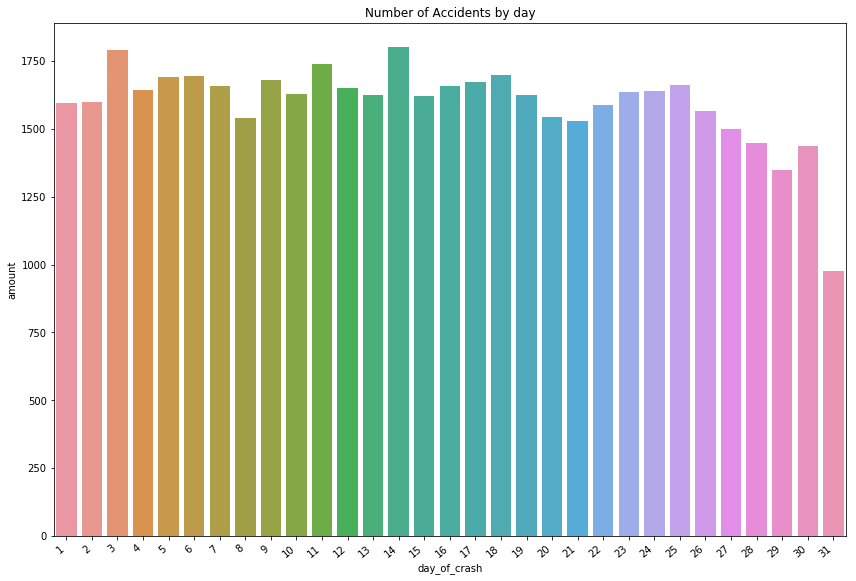

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (12, 8)
ax = sns.barplot(x=accidents_by_day_in_month.day_of_crash,y=accidents_by_day_in_month.amount)

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.title("Number of Accidents by day")
plt.show()

In [8]:
query = """SELECT COUNT(consecutive_number) as accidents,
                  EXTRACT(Hour FROM timestamp_of_crash)
            FROM `bigquery-public-data.nhtsa_traffic_fatalities.accident_2015`
            GROUP BY EXTRACT(Hour FROM timestamp_of_crash)
            ORDER BY COUNT(consecutive_number)
        """
accidents_by_hour = accidents.query_to_pandas_safe(query)

In [9]:
print(accidents_by_hour)

    accidents  f0_
0         751    4
1         910    8
2         946    3
3         958    9
4        1000    5
5        1019   10
6        1126   11
7        1146    7
8        1202    6
9        1207    2
10       1223   12
11       1226    1
12       1334   23
13       1387   13
14       1511   14
15       1513    0
16       1554   22
17       1650   16
18       1686   15
19       1784   19
20       1811   21
21       1838   17
22       1862   20
23       1895   18


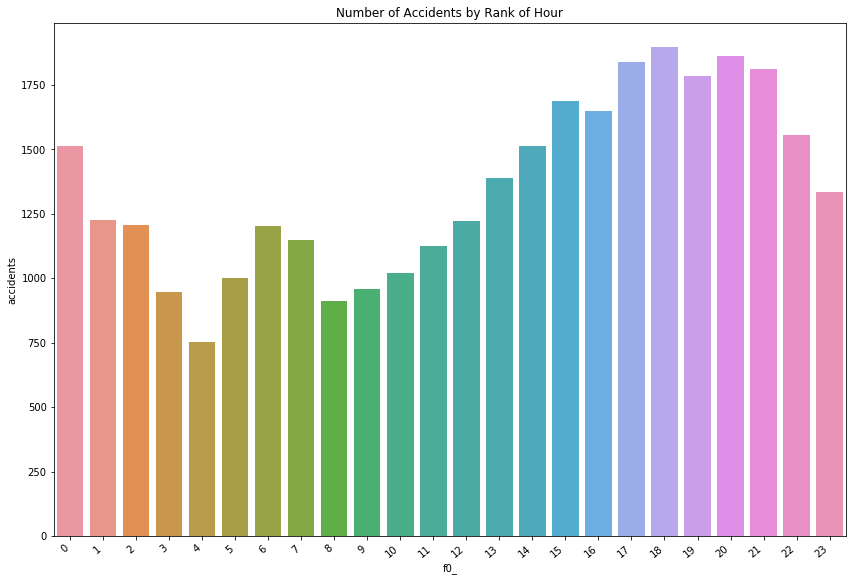

In [10]:
import seaborn as sns

plt.rcParams["figure.figsize"] = (12, 8)
ax = sns.barplot(x=accidents_by_hour.f0_,y=accidents_by_hour.accidents)

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.title("Number of Accidents by Rank of Hour")
plt.show()

In [11]:
query = """SELECT COUNT(hit_and_run) AS Amount,registration_state_name AS STATE
            FROM `bigquery-public-data.nhtsa_traffic_fatalities.vehicle_2015`
            WHERE hit_and_run = "Yes"
            GROUP BY registration_state_name
            ORDER BY COUNT(hit_and_run) DESC
        """
                 
hit_n_run_by_state = accidents.query_to_pandas_safe(query)

In [12]:
hit_n_run_by_state.head()

,Amount,STATE
0,834,Unknown
1,155,California
2,96,Florida
3,86,Texas
4,38,New York


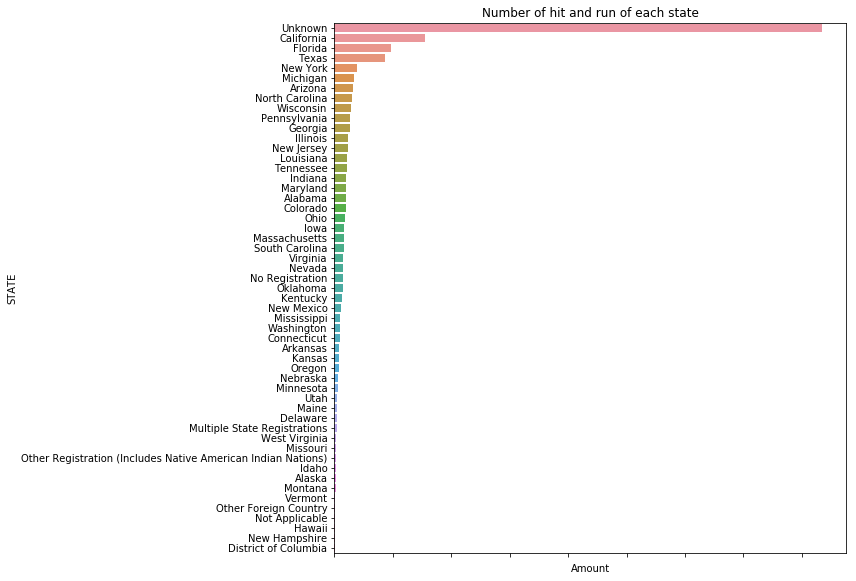

In [13]:
plt.rcParams["figure.figsize"] = (12, 8)
ax = sns.barplot(x=hit_n_run_by_state.Amount,y=hit_n_run_by_state.STATE)

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.title("Number of hit and run of each state")
plt.show()

**Here I want to dig deeper. Some extra work to make more progress on my SQL skills.**

My goal is to create a dataframe that I can generate multivariable plot

I want to have the hit and run I have and join the drunk driver solumn from accident_2015.
So that I can see the correlation between these two and maybe mark each point by state.
Here, I assumed the correlation between the amount of hit and run and the amount of drunk driver would be strongly positive.

In [14]:
query = """With a AS(
                    SELECT consecutive_number,number_of_drunk_drivers
                    FROM `bigquery-public-data.nhtsa_traffic_fatalities.accident_2015`
                    WHERE number_of_drunk_drivers > 0)
            SELECT v.registration_state_name AS STATE,
                   COUNT(v.hit_and_run) AS Hit_and_run_Amount,
                   SUM(a.number_of_drunk_drivers) as Drunk_Drivers
            FROM `bigquery-public-data.nhtsa_traffic_fatalities.vehicle_2015` v
            Join a
                ON v.consecutive_number = a.consecutive_number
            WHERE hit_and_run = "Yes"
            GROUP BY 1
            ORDER BY 3 DESC
        """
## You can use number (1,2,3) to stand for the columns you select

DrunkDriveEvent_by_state = accidents.query_to_pandas_safe(query)

- **About Join, you can refer to [here](https://www.kaggle.com/justjun0321/sql-scavenger-hunt-day-5-done-by-wei-chun-chang)**

In [15]:
DrunkDriveEvent_by_state.head()

,STATE,Hit_and_run_Amount,Drunk_Drivers
0,Unknown,47,49
1,California,41,47
2,Texas,28,30
3,Florida,28,30
4,Michigan,19,20


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


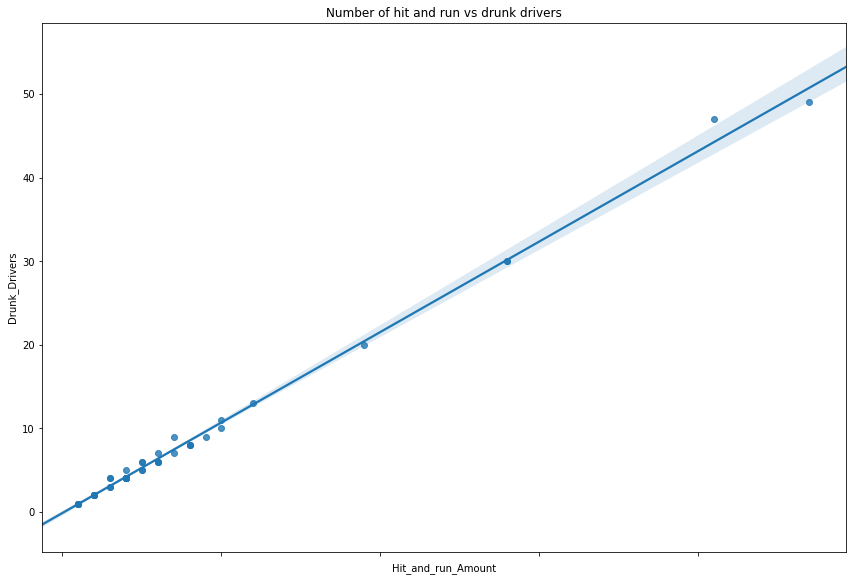

In [16]:
plt.rcParams["figure.figsize"] = (12, 8)
ax = sns.regplot(x="Hit_and_run_Amount", y="Drunk_Drivers", data=DrunkDriveEvent_by_state)

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.title("Number of hit and run vs drunk drivers")
plt.show()

As I assumed, the correlation is really strong.

In [17]:
Northeast_list = ['Connecticut','Maine','Massachusetts','New Hampshire','Rhode Island','Vermont','New Jersey','New York','Pennsylvania']
Midwest_list = ['Illinois','Indiana','Michigan','Ohio','Wisconsin','Iowa','Kansas','Minnesota','Missouri','Nebraska','North Dakota','South Dakota']
South_list = ['Delaware','Florida','Georgia','Maryland','North Carolina','South Carolina','Virginia','District of Columbia','West Virginia','Alabama','Kentucky','Mississippi','Tennesse','Arkansas','Louisiana','Oklahoma','Texas']
West_list = ['Arizona','Colorado','Idaho','Montana','Nevada','New Mexico','Utah','Wyoming','Alaska','California','Hawaii','Oregon','Washington']

In [18]:
'Arizona' in West_list

True

In [19]:
#DrunkDriveEvent_by_state['Region'] = 'Other'
#DrunkDriveEvent_by_state.loc[DrunkDriveEvent_by_state.STATE in Northeast_list,'Region']='Northeast'
#DrunkDriveEvent_by_state.loc[DrunkDriveEvent_by_state.STATE in Midwest_list,'Region']='Midwest'
#DrunkDriveEvent_by_state.loc[DrunkDriveEvent_by_state.STATE in Northeast_list,'Region']='South'
#DrunkDriveEvent_by_state.loc[DrunkDriveEvent_by_state.STATE in Northeast_list,'Region']='West'

> The code keep show the error : ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

Hope anyone can help me out

Since I fail to use the smart way to change the value, I can only use the stupid way as input every state name.

In [20]:
DrunkDriveEvent_by_state['Region'] = 'Other'
DrunkDriveEvent_by_state.loc[DrunkDriveEvent_by_state.STATE == 'Connecticut','Region']='Northeast'
DrunkDriveEvent_by_state.loc[DrunkDriveEvent_by_state.STATE == 'Maine','Region']='Northeast'
DrunkDriveEvent_by_state.loc[DrunkDriveEvent_by_state.STATE == 'Massachusetts','Region']='Northeast'
DrunkDriveEvent_by_state.loc[DrunkDriveEvent_by_state.STATE == 'New Hampshire','Region']='Northeast'
DrunkDriveEvent_by_state.loc[DrunkDriveEvent_by_state.STATE == 'Rhode Island','Region']='Northeast'
DrunkDriveEvent_by_state.loc[DrunkDriveEvent_by_state.STATE == 'Vermont','Region']='Northeast'
DrunkDriveEvent_by_state.loc[DrunkDriveEvent_by_state.STATE == 'New Jersey','Region']='Northeast'
DrunkDriveEvent_by_state.loc[DrunkDriveEvent_by_state.STATE == 'New York','Region']='Northeast'
DrunkDriveEvent_by_state.loc[DrunkDriveEvent_by_state.STATE == 'Pennsylvania','Region']='Northeast'

In [21]:
DrunkDriveEvent_by_state.loc[DrunkDriveEvent_by_state.STATE == 'Illinois','Region']='Midwest'
DrunkDriveEvent_by_state.loc[DrunkDriveEvent_by_state.STATE == 'Indiana','Region']='Midwest'
DrunkDriveEvent_by_state.loc[DrunkDriveEvent_by_state.STATE == 'Michigan','Region']='Midwest'
DrunkDriveEvent_by_state.loc[DrunkDriveEvent_by_state.STATE == 'Ohio','Region']='Midwest'
DrunkDriveEvent_by_state.loc[DrunkDriveEvent_by_state.STATE == 'Wisconsin','Region']='Midwest'
DrunkDriveEvent_by_state.loc[DrunkDriveEvent_by_state.STATE == 'Iowa','Region']='Midwest'
DrunkDriveEvent_by_state.loc[DrunkDriveEvent_by_state.STATE == 'Kansas','Region']='Midwest'
DrunkDriveEvent_by_state.loc[DrunkDriveEvent_by_state.STATE == 'Minnesota','Region']='Midwest'
DrunkDriveEvent_by_state.loc[DrunkDriveEvent_by_state.STATE == 'Missouri','Region']='Midwest'
DrunkDriveEvent_by_state.loc[DrunkDriveEvent_by_state.STATE == 'Nebraska','Region']='Midwest'
DrunkDriveEvent_by_state.loc[DrunkDriveEvent_by_state.STATE == 'North Dakota','Region']='Midwest'
DrunkDriveEvent_by_state.loc[DrunkDriveEvent_by_state.STATE == 'South Dakota','Region']='Midwest'

In [22]:
DrunkDriveEvent_by_state.loc[DrunkDriveEvent_by_state.STATE == 'Delaware','Region']='South'
DrunkDriveEvent_by_state.loc[DrunkDriveEvent_by_state.STATE == 'Florida','Region']='South'
DrunkDriveEvent_by_state.loc[DrunkDriveEvent_by_state.STATE == 'Georgia','Region']='South'
DrunkDriveEvent_by_state.loc[DrunkDriveEvent_by_state.STATE == 'Maryland','Region']='South'
DrunkDriveEvent_by_state.loc[DrunkDriveEvent_by_state.STATE == 'North Carolina','Region']='South'
DrunkDriveEvent_by_state.loc[DrunkDriveEvent_by_state.STATE == 'South Carolina','Region']='South'
DrunkDriveEvent_by_state.loc[DrunkDriveEvent_by_state.STATE == 'Virginia','Region']='South'
DrunkDriveEvent_by_state.loc[DrunkDriveEvent_by_state.STATE == 'District of Columbia','Region']='South'
DrunkDriveEvent_by_state.loc[DrunkDriveEvent_by_state.STATE == 'West Virginia','Region']='South'
DrunkDriveEvent_by_state.loc[DrunkDriveEvent_by_state.STATE == 'Alabama','Region']='South'
DrunkDriveEvent_by_state.loc[DrunkDriveEvent_by_state.STATE == 'Kentucky','Region']='South'
DrunkDriveEvent_by_state.loc[DrunkDriveEvent_by_state.STATE == 'Mississippi','Region']='South'
DrunkDriveEvent_by_state.loc[DrunkDriveEvent_by_state.STATE == 'Tennesse','Region']='South'
DrunkDriveEvent_by_state.loc[DrunkDriveEvent_by_state.STATE == 'Arkansas','Region']='South'
DrunkDriveEvent_by_state.loc[DrunkDriveEvent_by_state.STATE == 'Louisiana','Region']='South'
DrunkDriveEvent_by_state.loc[DrunkDriveEvent_by_state.STATE == 'Oklahoma','Region']='South'
DrunkDriveEvent_by_state.loc[DrunkDriveEvent_by_state.STATE == 'Texas','Region']='South'

In [23]:
DrunkDriveEvent_by_state.loc[DrunkDriveEvent_by_state.STATE == 'Arizona','Region']='West'
DrunkDriveEvent_by_state.loc[DrunkDriveEvent_by_state.STATE == 'Colorado','Region']='West'
DrunkDriveEvent_by_state.loc[DrunkDriveEvent_by_state.STATE == 'Idaho','Region']='West'
DrunkDriveEvent_by_state.loc[DrunkDriveEvent_by_state.STATE == 'Montana','Region']='West'
DrunkDriveEvent_by_state.loc[DrunkDriveEvent_by_state.STATE == 'Nevada','Region']='West'
DrunkDriveEvent_by_state.loc[DrunkDriveEvent_by_state.STATE == 'New Mexico','Region']='West'
DrunkDriveEvent_by_state.loc[DrunkDriveEvent_by_state.STATE == 'Utah','Region']='West'
DrunkDriveEvent_by_state.loc[DrunkDriveEvent_by_state.STATE == 'Wyoming','Region']='West'
DrunkDriveEvent_by_state.loc[DrunkDriveEvent_by_state.STATE == 'Alaska','Region']='West'
DrunkDriveEvent_by_state.loc[DrunkDriveEvent_by_state.STATE == 'California','Region']='West'
DrunkDriveEvent_by_state.loc[DrunkDriveEvent_by_state.STATE == 'Hawaii','Region']='West'
DrunkDriveEvent_by_state.loc[DrunkDriveEvent_by_state.STATE == 'Oregon','Region']='West'
DrunkDriveEvent_by_state.loc[DrunkDriveEvent_by_state.STATE == 'Washington','Region']='West'

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


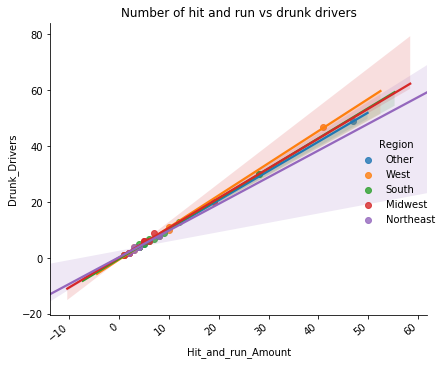

In [24]:
plt.rcParams["figure.figsize"] = (12, 8)
ax = sns.lmplot(x="Hit_and_run_Amount", y="Drunk_Drivers", data=DrunkDriveEvent_by_state,hue= "Region")

ax.set_xticklabels(rotation=40, ha="right")
plt.tight_layout()
plt.title("Number of hit and run vs drunk drivers")
plt.show()

I can see that the slope of West region is the highest and that of Northeast is the lowest.

Also, I can see that the point with the highest "Hit and run amount" and "Drunk drivers" is in Other region.

And that one is Unknown.

In [25]:
DrunkDriveEvent_by_state.head()

,STATE,Hit_and_run_Amount,Drunk_Drivers,Region
0,Unknown,47,49,Other
1,California,41,47,West
2,Texas,28,30,South
3,Florida,28,30,South
4,Michigan,19,20,Midwest


I want to plot State map filled by color demonstrating the amount of Hit and run and that of drunk driver.

The way I plot refer to [here](https://stackoverflow.com/questions/7586384/color-states-with-pythons-matplotlib-basemap)

In [26]:
#from matplotlib.patches import Polygon

#Map = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
#        projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
#Map.readshapefile('st99_d00', name='states', drawbounds=True)

#state_names = []
#for shape_dict in map.states_info:
#    state_names.append(shape_dict['NAME'])
    
#ax = plt.gca()

#seg = Map.states[DrunkDriveEvent_by_state['STATE']]
#poly = Polygon(seg, facecolor='red',edgecolor='red')
#ax.add_patch(poly)

#plt.show()

OK, now I want to see where did these drunk drivers have accidents.

So my goal is to plot a US map and have corresponded points on the map 

In [27]:
query = """With a AS(
                    SELECT consecutive_number,number_of_drunk_drivers,latitude,
                    longitude,number_of_motor_vehicles_in_transport_mvit
                    FROM `bigquery-public-data.nhtsa_traffic_fatalities.accident_2015`
                    WHERE number_of_drunk_drivers > 0)
            SELECT ROUND(latitude,0) as latitude,
                   ROUND(longitude,0) as longtitude,
                   COUNT(v.hit_and_run) AS Hit_and_run_Amount,
                   SUM(a.number_of_drunk_drivers) as Drunk_Drivers
            FROM `bigquery-public-data.nhtsa_traffic_fatalities.vehicle_2015` v
            Join a
                ON v.consecutive_number = a.consecutive_number
            WHERE hit_and_run = "Yes"
            GROUP BY 1,2
            ORDER BY 4 DESC
        """

DrunkDriveEvent_map = accidents.query_to_pandas_safe(query)

In [28]:
DrunkDriveEvent_map

,latitude,longtitude,Hit_and_run_Amount,Drunk_Drivers
0,34.0,-118.0,20,24
1,42.0,-83.0,12,13
2,36.0,-115.0,9,10
3,43.0,-88.0,5,7
4,39.0,-77.0,7,7
5,42.0,-88.0,6,7
6,33.0,-97.0,7,7
7,28.0,-82.0,6,6
8,40.0,-105.0,6,6
9,30.0,-95.0,5,5


In [29]:
DrunkDriveEvent_map.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 4 columns):
latitude              180 non-null float64
longtitude            180 non-null float64
Hit_and_run_Amount    180 non-null int64
Drunk_Drivers         180 non-null int64
dtypes: float64(2), int64(2)
memory usage: 5.7 KB


Map plotting refer to [here](https://www.kaggle.com/camnugent/geographic-distribution-of-fatal-car-accidents)

In [30]:
DrunkDriveEvent_map.Drunk_Drivers = DrunkDriveEvent_map.Drunk_Drivers.astype(float)
DrunkDriveEvent_map.Hit_and_run_Amount = DrunkDriveEvent_map.Hit_and_run_Amount.astype(float)

/opt/conda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1704: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/opt/conda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


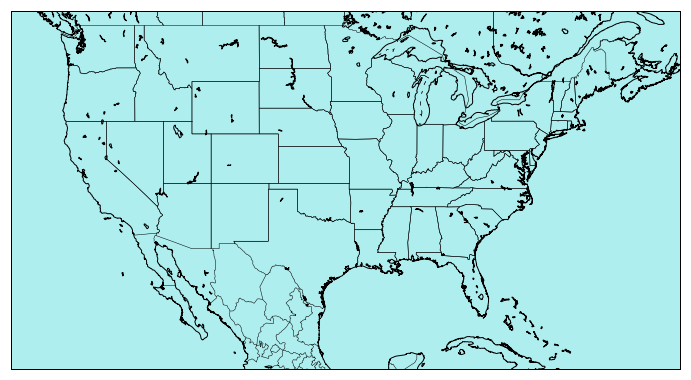

In [31]:
import numpy as np
from mpl_toolkits.basemap import Basemap

Map = Basemap(projection='merc',llcrnrlat=20,urcrnrlat=50,llcrnrlon=-130.,urcrnrlon=-60.,lat_ts=20,resolution='i')
Map.drawmapboundary(fill_color='paleturquoise')
Map.drawcoastlines()
Map.drawcountries()
Map.drawstates()
used = set()

min_marker_size = 0.5
for i in range(0,179):
    x,y = Map(DrunkDriveEvent_map.longtitude[i], DrunkDriveEvent_map.latitude[i])
    msize = min_marker_size * DrunkDriveEvent_map.Drunk_Drivers[i]
    Map.plot(x, y, markersize=msize)
    
plt.show()

/opt/conda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1704: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/opt/conda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


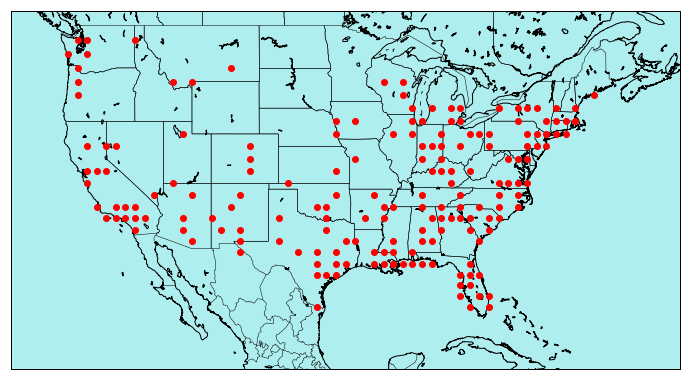

In [32]:
import numpy as np
from mpl_toolkits.basemap import Basemap

Map = Basemap(projection='merc',llcrnrlat=20,urcrnrlat=50,llcrnrlon=-130.,urcrnrlon=-60.,lat_ts=20,resolution='i')
Map.drawmapboundary(fill_color='paleturquoise')
Map.drawcoastlines()
Map.drawcountries()
Map.drawstates()
used = set()

x,y = Map(DrunkDriveEvent_map['longtitude'].values, DrunkDriveEvent_map['latitude'].values)
Map.plot(x, y, 'ro')
    
plt.show()

I want to add on size by Drunk_Drivers and color by Hit_and_run_Amount.

I'm still trying to figure it out how to achieve this

Hope anyone can help me with this.

In [ ]:
query = """SELECT COUNT(consecutive_number) as accidents,
                  EXTRACT(Hour FROM timestamp_of_crash)
            FROM `bigquery-public-data.nhtsa_traffic_fatalities.accident_2015`
            GROUP BY EXTRACT(Hour FROM timestamp_of_crash)
            ORDER BY COUNT(consecutive_number)
        """
accidents_by_hour = accidents.query_to_pandas_safe(query)

<font size=4>Feel free to upvote and leave comments</font>